In [49]:
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import tensorflow as tf
import numpy as np
import pandas as pd
import tf2onnx # Buat simpan model ke ONNX
from sklearn.preprocessing import MinMaxScaler # Buat scaling data
from sklearn import metrics # Buat evaluasi model
from sklearn.metrics import r2_score # R2 score
from datetime import datetime, timedelta # Buat atur tanggal
from keras.models import Sequential # Model Sequential Keras
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Dropout, LSTM, Bidirectional, BatchNormalization # Layer-layer model
from keras.metrics import RootMeanSquaredError as rmse # Metrik RMSE

# Cek versi TensorFlow (biar yakin)
print(f"TensorFlow Version: {tf.__version__}")
# Cek support GPU (penting buat training cepet)
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Inisialisasi MetaTrader5 (buat ambil data histori)
if not mt5.initialize():
    print(f"initialize() failed, error code = {mt5.last_error()}")
    quit()

# Tunjukin info terminal MT5
terminal_info = mt5.terminal_info()
print(f"MetaTrader5 Terminal Info: {terminal_info}")

# Tentukan path buat simpan model (ini bisa kamu sesuaikan)
# Contoh: simpan di folder MQL5 Files MetaTrader5
file_path = terminal_info.data_path + "\\MQL5\\Files\\"
print(f"Model save path: {file_path}")

TensorFlow Version: 2.10.0
GPU Available: True
MetaTrader5 Terminal Info: TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=True, trade_allowed=True, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=True, build=4885, maxbars=100000, codepage=0, ping_last=21494, community_balance=0.0, retransmission=5.328719134752738, company='MetaQuotes Ltd.', name='MetaTrader 5', language='English', path='C:\\Program Files\\MetaTrader 5', data_path='C:\\Users\\User\\AppData\\Roaming\\MetaQuotes\\Terminal\\D0E8209F77C8CF37AD8BF550E51FF075', commondata_path='C:\\Users\\User\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')
Model save path: C:\Users\User\AppData\Roaming\MetaQuotes\Terminal\D0E8209F77C8CF37AD8BF550E51FF075\MQL5\Files\


# Data Collection

In [50]:
# Tentukan tanggal mulai dan akhir untuk data histori
end_date = datetime.now() # Ambil sampai tanggal hari ini
start_date = datetime(2020, 1, 1) # Mulai dari 1 Januari 2020

print(f"Data Start Date: {start_date}")
print(f"Data End Date: {end_date}")

# Ambil data harga XAUUSD (Timeframe H1) dari MT5
# time_step yang digunakan MT5.TIMEFRAME_H1 (1 jam)
xauusd_rates = mt5.copy_rates_range("XAUUSD", mt5.TIMEFRAME_H1, start_date, end_date)

# Bikin DataFrame dari data yang diambil
df = pd.DataFrame(xauusd_rates)
df['time'] = pd.to_datetime(df['time'], unit='s') # Ubah timestamp ke datetime
df = df.set_index('time') # Set kolom 'time' jadi index

# Cek beberapa baris awal dan akhir DataFrame
print("\nDataFrame Head:")
print(df.head())
print("\nDataFrame Tail:")
print(df.tail())
print(f"\nDataFrame Shape: {df.shape}") # Liat berapa banyak data (rows, columns)

# Kita cuma butuh kolom 'close' untuk prediksi
data = df['close'].values.reshape(-1, 1) # Reshape biar jadi 2D array

Data Start Date: 2020-01-01 00:00:00
Data End Date: 2025-06-01 07:29:59.151434

DataFrame Head:
                open      high       low     close  tick_volume  spread  \
time                                                                      
2020-01-02  1518.594  1531.405  1517.302  1528.873        49576       0   
2020-01-03  1528.855  1553.549  1528.855  1552.013        66824       0   
2020-01-05  1576.486  1582.334  1566.985  1569.346         5740       0   
2020-01-06  1569.281  1580.096  1560.948  1563.836        72196       0   
2020-01-07  1563.853  1598.474  1555.407  1595.143        74863       0   

            real_volume  
time                     
2020-01-02            0  
2020-01-03            0  
2020-01-05            0  
2020-01-06            0  
2020-01-07            0  

DataFrame Tail:
                         open      high       low     close  tick_volume  \
time                                                                       
2025-05-30 16:00:00  3288.6

# Preprocessing

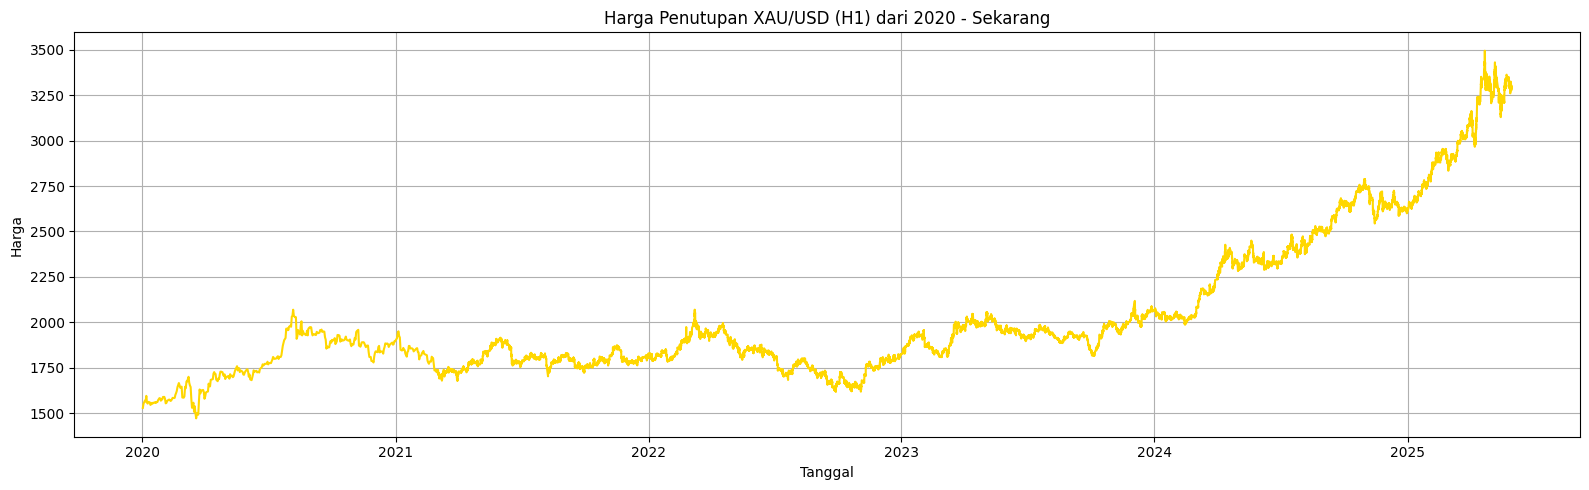

In [51]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Visualisasi harga penutupan XAU/USD (H1)
plt.figure(figsize=(16, 5))
plt.plot(df.index, df['close'], color='gold')
plt.title('Harga Penutupan XAU/USD (H1) dari 2020 - Sekarang')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.grid(True)
plt.tight_layout()
plt.show()

# Normalisasi menggunakan MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)


# Feature Engineering

In [52]:
# Bagi data ke train dan test (misal 80%:20%)
train_size = int(len(data_scaled) * 0.8)
train_data_scaled = data_scaled[:train_size]
test_data_scaled = data_scaled[train_size:]

In [53]:
# Time step untuk LSTM (misal 120 jam sebelumnya)
time_step = 480

In [54]:

# Fungsi split sequence
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [55]:

# Gunakan fungsi di atas
x_train, y_train = split_sequence(train_data_scaled, time_step)
x_test, y_test = split_sequence(test_data_scaled, time_step)


In [56]:

# Reshape untuk input LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [57]:
# # Misalnya X dan y sudah dalam bentuk array dari step sebelumnya
# train_size = int(len(X) * 0.8)
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# print(f"X_train shape: {X_train.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"X_test shape: {X_test.shape}")
# print(f"y_test shape: {y_test.shape}")


# Model Architechture

In [58]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()

# Layer LSTM pertama
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.3))

# Layer LSTM kedua (deep)
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))

# Layer LSTM ketiga (terakhir)
model.add(LSTM(32))
model.add(Dropout(0.3))

# Layer output, hanya 1 nilai prediksi
model.add(Dense(1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Lihat arsitekturnya
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 480, 64)           16896     
                                                                 
 dropout_6 (Dropout)         (None, 480, 64)           0         
                                                                 
 lstm_7 (LSTM)               (None, 480, 64)           33024     
                                                                 
 dropout_7 (Dropout)         (None, 480, 64)           0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

# Training

In [59]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)


Epoch 1/20
311/311 [==============================] - 23s 69ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 2/20
311/311 [==============================] - 21s 67ms/step - loss: 5.4598e-04 - val_loss: 0.0013
Epoch 3/20
311/311 [==============================] - 20s 65ms/step - loss: 3.6620e-04 - val_loss: 0.0012
Epoch 4/20
311/311 [==============================] - 20s 64ms/step - loss: 2.6394e-04 - val_loss: 5.6321e-04
Epoch 5/20
311/311 [==============================] - 20s 64ms/step - loss: 2.0224e-04 - val_loss: 4.7662e-04
Epoch 6/20
311/311 [==============================] - 20s 64ms/step - loss: 1.7361e-04 - val_loss: 0.0013
Epoch 7/20
311/311 [==============================] - 21s 67ms/step - loss: 1.5881e-04 - val_loss: 7.3119e-04
Epoch 8/20
311/311 [==============================] - 43s 137ms/step - loss: 1.4857e-04 - val_loss: 6.9222e-04
Epoch 9/20
311/311 [==============================] - 28s 90ms/step - loss: 1.6124e-04 - val_loss: 0.0013
Epoch 10/20
311/311 [============

# Evaluation

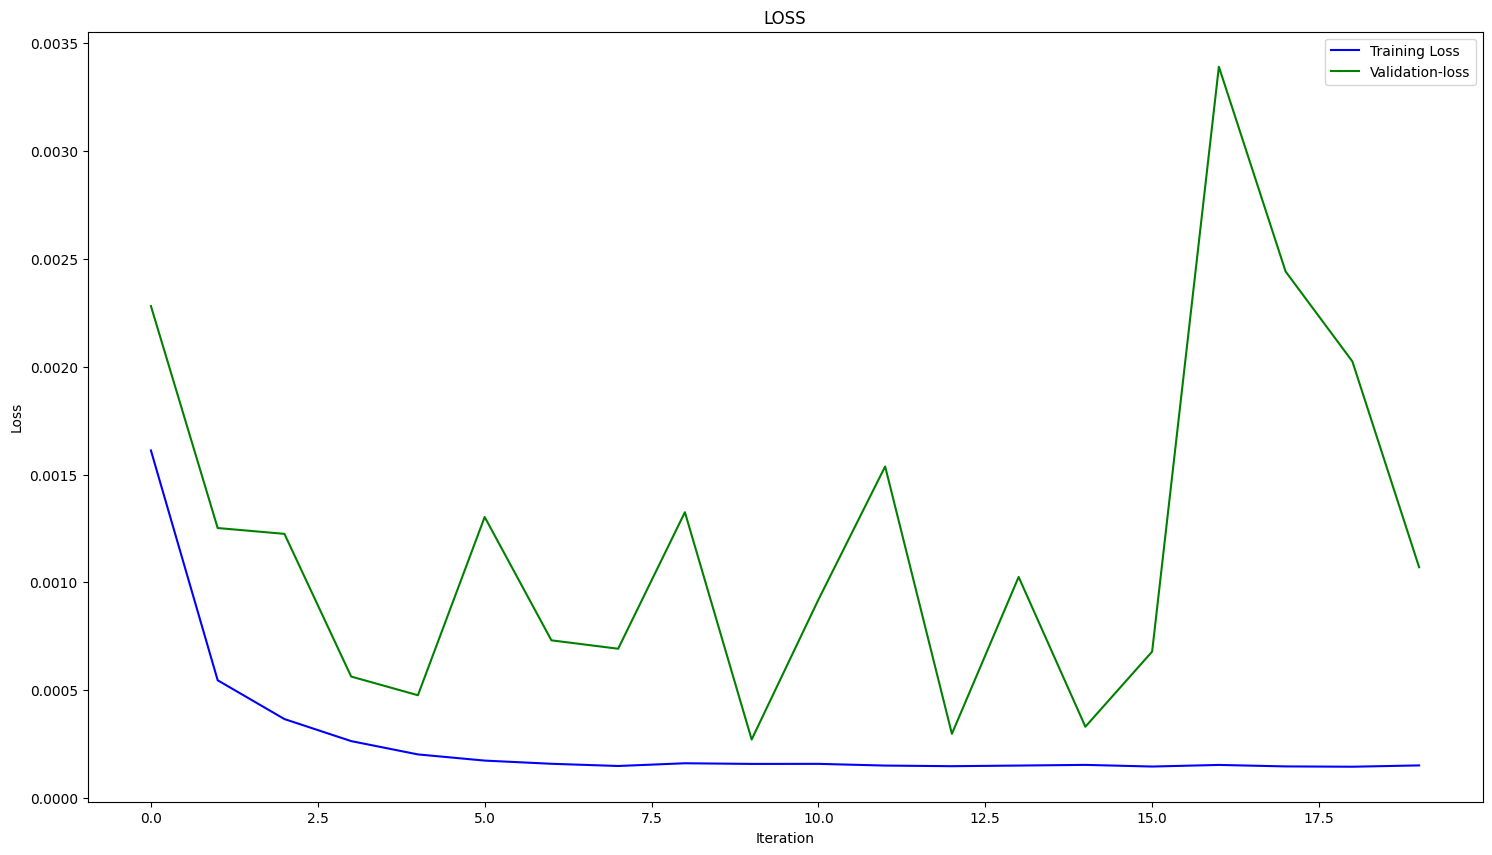

In [60]:
#show iteration-loss graph for training and validation
plt.figure(figsize = (18,10))
plt.plot(history.history['loss'],label='Training Loss',color='b')
plt.plot(history.history['val_loss'],label='Validation-loss',color='g')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("LOSS")
plt.legend()

In [61]:
#evaluate training data
model.evaluate(x_train,y_train, batch_size = 32)

622/622 [==============================] - 16s 26ms/step - loss: 1.2201e-05


1.220138801727444e-05

In [62]:
#evaluate testing data
model.evaluate(x_test,y_test, batch_size = 32)

145/145 [==============================] - 4s 26ms/step - loss: 0.0011


0.0010700952261686325

In [63]:
#prediction using training data
train_predict = model.predict(x_train)
plot_y_train = y_train.reshape(-1,1)

622/622 [==============================] - 16s 25ms/step


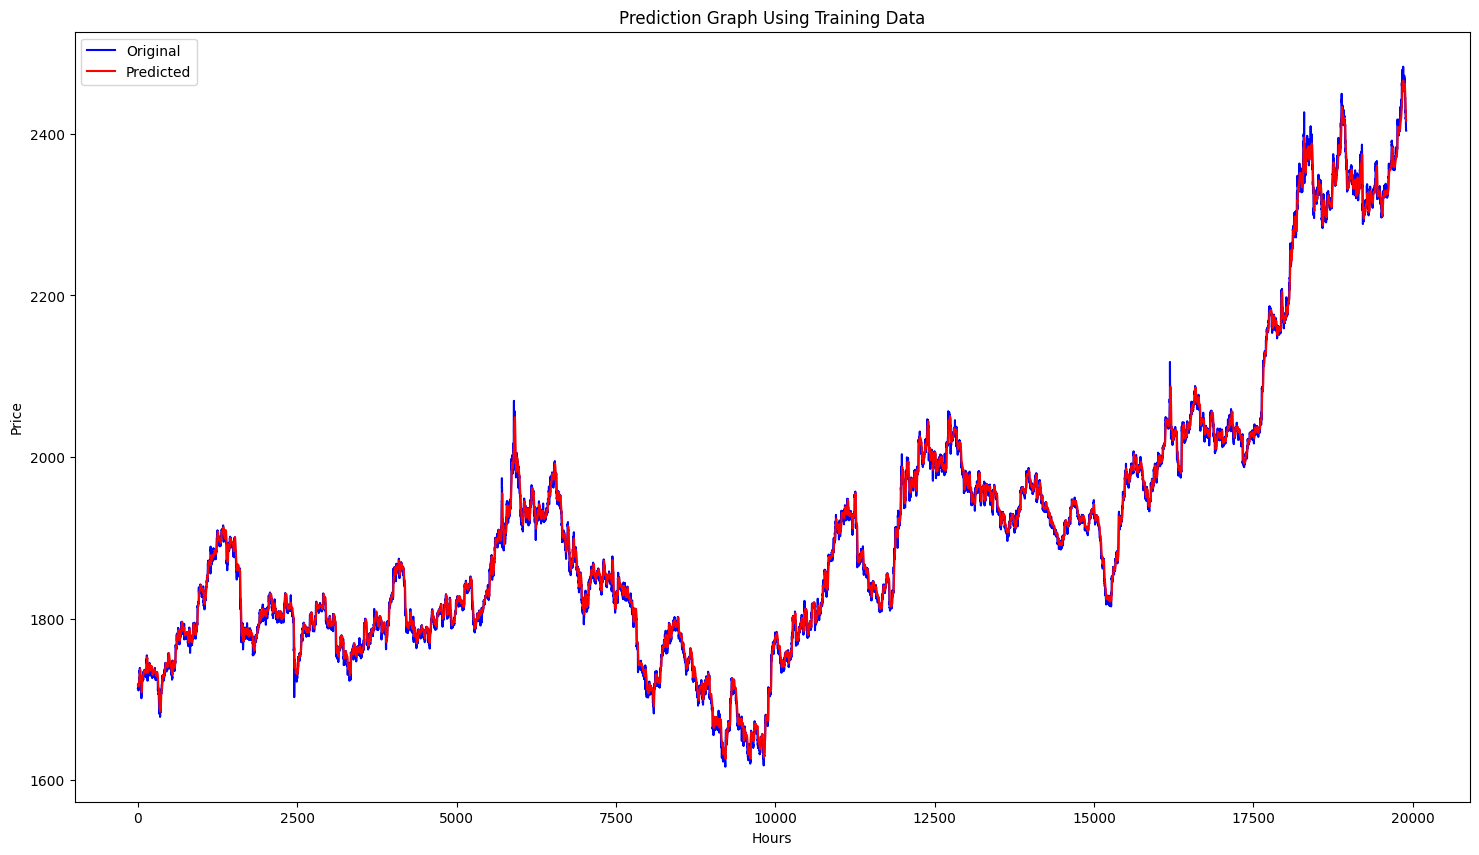

In [64]:
#show actual vs predicted (training) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_train),color = 'b', label = 'Original')
plt.plot(scaler.inverse_transform(train_predict),color='red', label = 'Predicted')
plt.title("Prediction Graph Using Training Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()

In [65]:
#prediction using testing data
test_predict = model.predict(x_test)
plot_y_test = y_test.reshape(-1,1)

145/145 [==============================] - 4s 26ms/step


In [66]:
#calculate metrics
from sklearn import metrics
from sklearn.metrics import r2_score
#transform data to real values
value1=scaler.inverse_transform(plot_y_test)
value2=scaler.inverse_transform(test_predict)
#calc score
score = np.sqrt(metrics.mean_squared_error(value1,value2))
print("RMSE         : {}".format(score))
print("MSE          :", metrics.mean_squared_error(value1,value2))
print("R2 score     :",metrics.r2_score(value1,value2))

RMSE         : 66.17615003764351
MSE          : 4379.282833804705
R2 score     : 0.9357195886145846


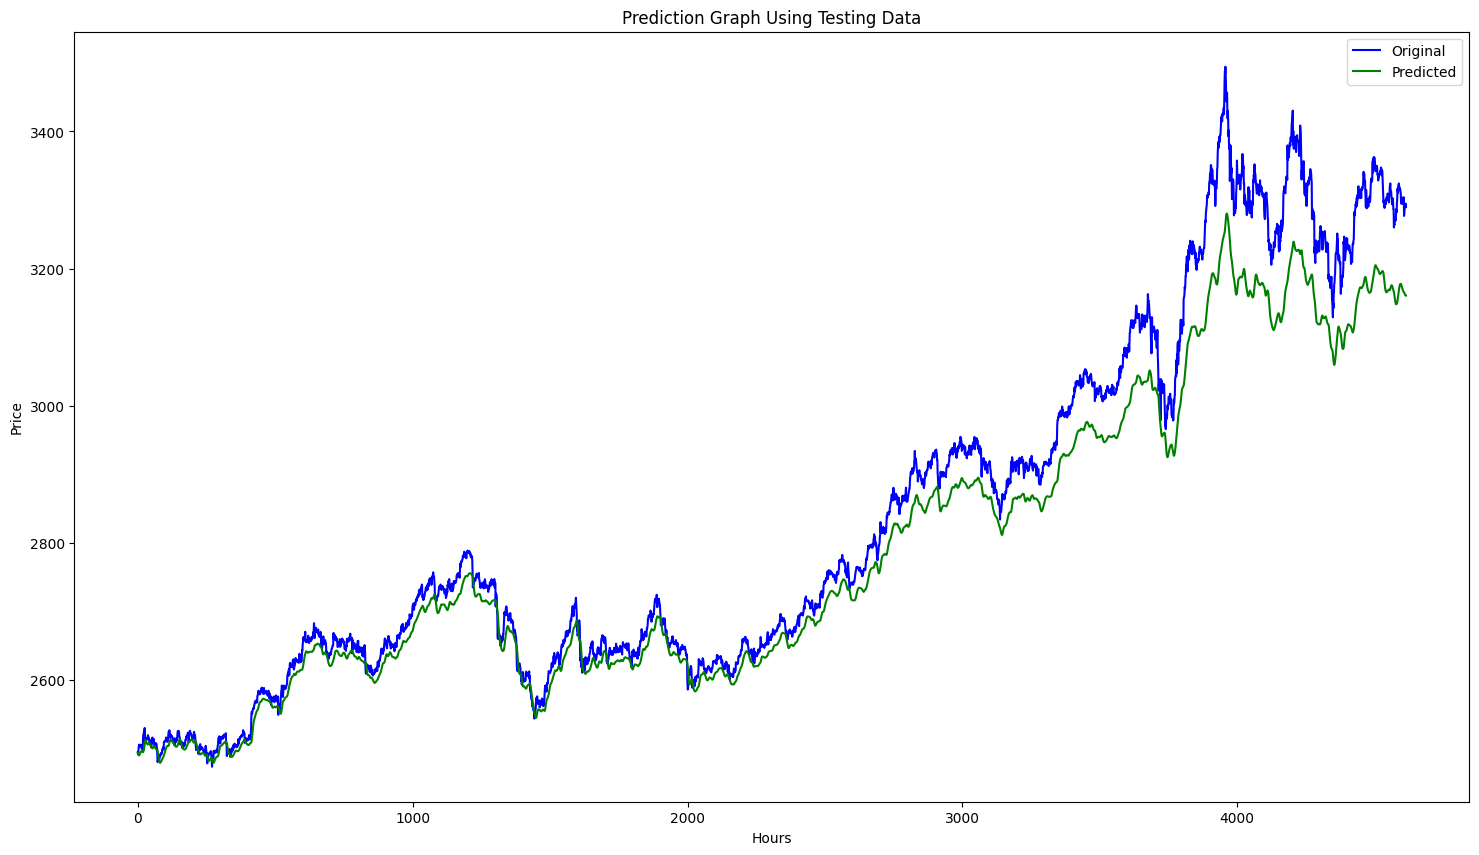

In [67]:
#show actual vs predicted (testing) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_test),color = 'b',  label = 'Original')
plt.plot(scaler.inverse_transform(test_predict),color='g', label = 'Predicted')
plt.title("Prediction Graph Using Testing Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()

In [68]:
# # save model to ONNX
# output_path = file_path+"model.xauusd.H1.120.onnx"
# onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)
# print(f"model saved to {output_path}")

# output_path = "model.xauusd.H1.120.onnx"
# onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)
# print(f"saved model to {output_path}")

# # finish
# mt5.shutdown()